In [2]:
import Cluster
import cProfile
import glob
import partition
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.preprocessing import StandardScaler

import imblearn
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn import decomposition
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.base import SamplerMixin

from sklearn.metrics import confusion_matrix, f1_score

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn import svm
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [2]:
TILE_SIZE = 25

In [3]:
## Loading
recover = open('./examples/_DONEIN700-SN142.p', 'rb')
input_list = pickle.load(recover)
print(len(input_list))

174257


In [4]:
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

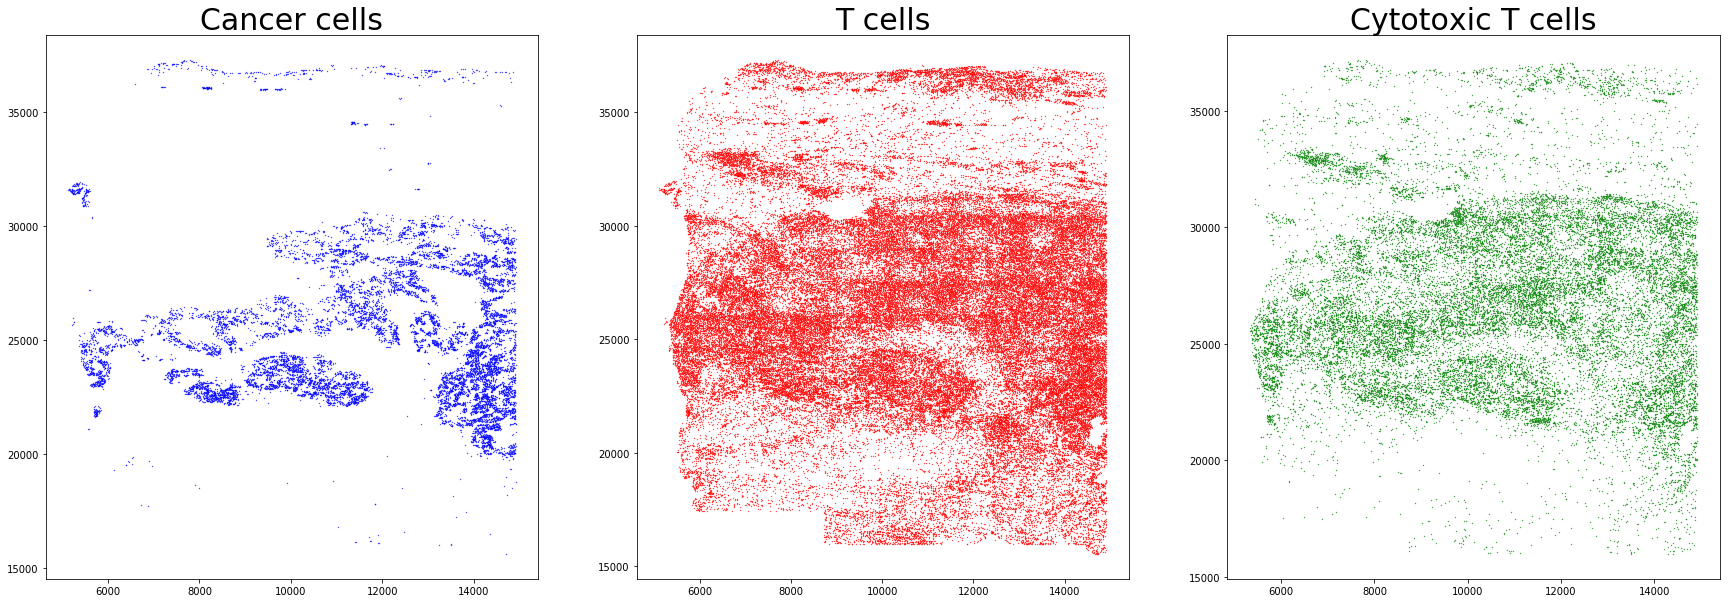

In [5]:
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

100%|██████████| 25/25 [00:00<00:00, 1237.61it/s]


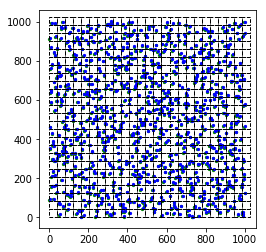

1000it [00:01, 687.57it/s]
100%|██████████| 25/25 [00:00<00:00, 43.16it/s]s]


True 863


In [6]:
# Example cases for clustering algorithms - this is where I visualised the various inputs for test.py
NUM_POINTS = 1000

def get_histo(du):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    for i in du:
        if i is None:
            raise TypeError
        value = len(i.cells)
        total_cluster_cells += len(i.cells)
        if value > 20:
            histogram[20] += 1
        else:
            histogram[value - 1] += 1
    return histogram, total_cluster_cells

check_again = False

if not check_again:
    random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
    random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

# print("cleaning...")
Cluster_result1 = Cluster.simplest(random_points)
# print("fishing...")
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

dups1 = set()
dups2 = set()

# # # Simplest
for key, value in Cluster_result1.items():
    if value not in dups1:
        dups1.add(value)

# # # Fisherman's
for i in Cluster_result2:
    dups2.add(i)

print(len(dups1) == len(dups2), len(dups1))
# print("dups (length is %d):" % len(dups2))

histo1, total_cluster_cells1 = get_histo(dups1)
histo2, total_cluster_cells2 = get_histo(dups2)

if (total_cluster_cells1 != total_cluster_cells2) or not np.array_equal(histo1, histo2):
    print("ERROR")
    print(histo1)

    
    print(histo2)

In [87]:
dups = set()

# # # Fisherman's
for i in result:
    dups.add(i)

best_range = [0, 0]

average = 0

temp = list(dups)

for i, cluster in enumerate(temp[0:-15]):
    local_average = len(temp[i].cells)
    delta = 0
    for j in range(i, i+15):
        local_average += len(temp[j].cells)
#         if abs(len(temp[j].cells) - temp[i].cells) > delta
    if local_average > average and local_average < 30:
        average = local_average
        best_range = [i, i+15]

print(average)
print(best_range)

29
[108, 123]


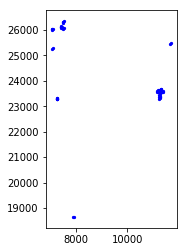

In [88]:
cluster_points_xMin = []
cluster_points_xMax = []
cluster_points_yMin = []
cluster_points_yMax = []
for cluster in temp[108:123]:
    for i, item in enumerate(cluster.cells):
        if i == 0:
            cluster_points_xMin.append(item[0])
            cluster_points_xMax.append(item[1])
            cluster_points_yMin.append(item[2])
            cluster_points_yMax.append(item[3])
        else:
            cluster_points_xMin.append(item[0][0])
            cluster_points_xMax.append(item[0][1])
            cluster_points_yMin.append(item[0][2])
            cluster_points_yMax.append(item[0][3])
            
cluster_points_xMin = np.array(cluster_points_xMin)
cluster_points_xMax = np.array(cluster_points_xMax)
cluster_points_yMin = np.array(cluster_points_yMin)
cluster_points_yMax = np.array(cluster_points_yMax)
            
fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )
plt.show()

In [7]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")

100%|██████████| 25/25 [00:00<00:00, 489.66it/s]

cells partitioned ...


In [ ]:
# Starts off slowly, as we expect - comparing cells against pretty much every other cell.
# The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
# all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
cProfile.run("Cluster.simplest(cancer_cells)")

In [10]:
# The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in around 10 
# or so seconds in comparison to ~3.5 minutes for the one above.
# This algorithm makes 2209284 neighbour comparisons in comparison to the above algorithm's 95268306.
# That's a difference of nearly 2 orders of magnitude already, and this is for a comparatively very small example. 
# Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)")

100%|██████████| 25/25 [00:12<00:00,  2.02it/s]/s]


         2890803 function calls in 12.398 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:147(__enter__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
       26    0.000    0

In [86]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)

100%|██████████| 25/25 [00:12<00:00,  2.05it/s]/s]


In [13]:
cluster_points_xMin = []
cluster_points_xMax = []
cluster_points_yMin = []
cluster_points_yMax = []


for cluster in result[200:215]:
    cluster_points_xMin.extend([item[0] for item in cluster.cells])
    cluster_points_xMax.extend([item[1] for item in cluster.cells])
    cluster_points_yMin.extend([item[2] for item in cluster.cells])
    cluster_points_yMax.extend([item[3] for item in cluster.cells])
    
cluster_points_xMin = np.array(cluster_points_xMin)
cluster_points_xMax = np.array(cluster_points_xMax)
cluster_points_yMin = np.array(cluster_points_yMin)
cluster_points_yMax = np.array(cluster_points_yMax)
    
print("cluster", cluster, ".length: ", len(cluster.cells))

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )
plt.show()

# tile_numbers = []
# dups = []
# histogram = np.zeros(21, dtype=np.uint32)

# for value in result:
#     dups.append(value)
        
# print("dups (length is %d):" % len(dups))
# total_cluster_cells = 0

# clusters_sum = 0
# dups_length = len(dups)

# for i in dups:
#     value = len(i.cells)
#     clusters_sum += value
#     total_cluster_cells += len(i.cells)
#     if value > 20:
#         histogram[20] += 1
#     else:
#         histogram[value - 1] += 1
                
# clusters_avg = clusters_sum / dups_length

# print("Total number of cells:", total_cluster_cells)

# print(histogram)

100%|██████████| 25/25 [00:11<00:00,  2.13it/s]/s]


IndexError: tuple index out of range

Sum: 0.9999999962747097


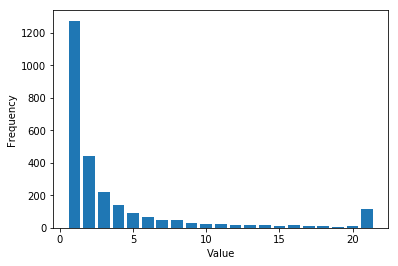

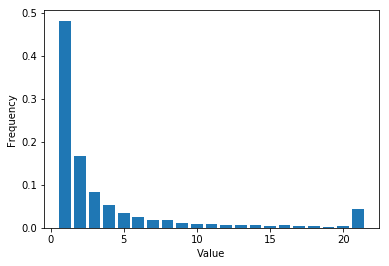

In [118]:
fig = plt.figure()

histogram, total_cluster_cells1 = get_histo(dups)

histogram_normed = histogram.astype(np.float32)
        
my_sum = sum(histogram_normed)

aggregate = 0

for i, x in enumerate(histogram_normed):
    aggregate += histogram_normed[i] / my_sum
    histogram_normed[i] /= my_sum
    
print("Sum:", np.sum(histogram_normed, dtype=np.float64))
    
    
y_normed = np.array(histogram_normed)
y = np.array(histogram)
x = np.arange(21) + 1

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.figure()
plt.bar(x, y_normed)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster", cluster, ".length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

In [ ]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [3]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    print(file[9:], ", ", sum(arr), ", ")
    my_sum = sum(arr)
    arr = arr / my_sum
    print(arr)
    X[i] = arr
                
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_res, y_res = sampler.fit_sample(X, y)

X_minority = np.take(X_res, np.where(y_res == 1), axis=0)[0]
y_minority = np.take(y_res, np.where(y_res == 1), axis=0)[0]

print(X_minority.shape, y_minority.shape)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)

_DONEIN700-SN142.txt ,  2644.0 , 
[0.4822239  0.16792738 0.08434191 0.05219365 0.03366112 0.02571861
 0.01928896 0.01853253 0.01134644 0.00832073 0.00794251 0.00642965
 0.00605144 0.00567322 0.00378215 0.00642965 0.00453858 0.00340393
 0.0026475  0.00491679 0.04462935]
_outDONEIN-783-SN33.txt ,  35008.0 , 
[0.52867913 0.16616201 0.07775366 0.04504685 0.03125    0.02253771
 0.01736746 0.01273995 0.00982633 0.00931216 0.00759826 0.00582724
 0.00557016 0.00485603 0.00474177 0.0038277  0.00334209 0.0027708
 0.00228519 0.00228519 0.03622029]
_outDONEIN704-SN157.txt ,  35583.0 , 
[0.44566226 0.14875081 0.07736841 0.04957423 0.03479189 0.02748504
 0.02057162 0.01582216 0.01461372 0.01194391 0.01081977 0.00876823
 0.00792513 0.00711014 0.00604221 0.00542394 0.00488998 0.00441222
 0.00429981 0.00410308 0.08962145]
_outDONEIN708-SN24.txt ,  61693.0 , 
[0.5161688  0.1566142  0.08177589 0.04948698 0.03318043 0.02374662
 0.01839755 0.0137779  0.01154102 0.00828295 0.00791014 0.00661339
 0.00543011 

In [ ]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

# def plot_decision_function(X, y, clf, ax):
#     plot_step = 0.02
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                          np.arange(y_min, y_max, plot_step))

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, alpha=0.4)
#     ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

class FakeSampler(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))
print(X.shape, y.shape)
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_resampling(X, y, sampler, ax2)
ax2.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

In [ ]:
# fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# plot_decision_function(X, y, clf, ax1)
# ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
# fig.tight_layout()

In [ ]:
def normalise(arr):
    my_sum = sum(arr)
    mean = my_sum / arr.size
    stddev = np.std(arr)

    arr -= mean
    arr /= stddev

    return arr

X = np.empty((59, 625))

for i, file in enumerate(sorted(glob.glob("./inputs/spatial/*.txt"))):
    f = open(file,'r')
    lines = f.readlines()
    arr = np.zeros((25, 25), dtype=np.float32)
    
    arr_i = 0
    to_skip = []
    for x, line in enumerate(lines):
        if ']' in line and x not in to_skip:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
            arr_i += 1
        elif ']' not in line:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            build_list = [int(s) for s in cleaned.split() if s.isdigit()]
            index = x
            while ']' not in line:
                index += 1
                to_skip.append(index)
                line = lines[index]
                cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
                build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
            arr[arr_i] = np.array(build_list)
            arr_i += 1
    
    arr = arr.reshape(625)
    
#     arr = normalise(arr)

    X[i] = arr
    f.close()

print(X.shape)
y = np.zeros([59], dtype=np.float32)

for index in positives:
    y[index] = 1

for (i, pair) in enumerate(zip(X, sorted(glob.glob("./inputs/spatial/*.txt")))):
    (matrix, name) = pair
    temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
    fig = plt.figure()
    plt.imshow(temp, cmap='hot', origin='lower')
    plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
    plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1-score for SVM: 0.67 (+/- 0.34)
F1-score for NB: 0.66 (+/- 0.28)
F1-score for DT-basic: 0.68 (+/- 0.30)
F1-score for DT-adjusted: 0.69 (+/- 0.35)


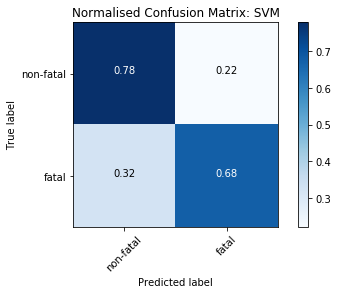

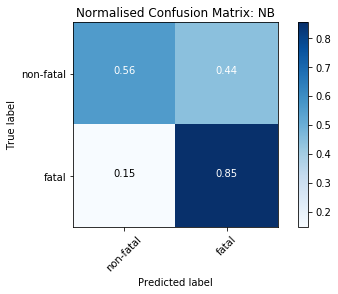

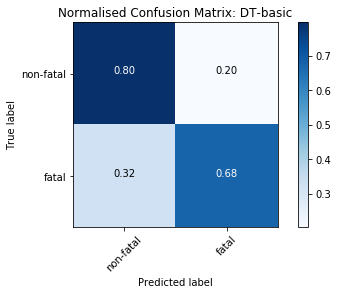

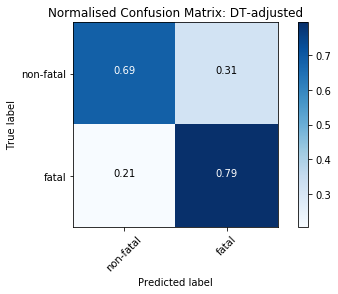

In [5]:
nb_priors = np.array([0.39, 0.61])
svm_params = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000]}

class_names = ['non-fatal', 'fatal']

classifiers = [GridSearchCV(svm.SVC(), svm_params), 
                GaussianNB(nb_priors),
                DecisionTreeClassifier(random_state=0),
                DecisionTreeClassifier(random_state=0, max_depth=3, class_weight='balanced')]
names = ["SVM", "NB", "DT-basic", "DT-adjusted"]

# X_res, y_res = shuffle(X_res, y_res, random_state=0)
for clf, name in zip(classifiers, names):
    y_pred = cross_val_predict(clf, X_res, y_res, cv=10)
    scores = cross_val_score(clf, X_res, y_res, cv=10, scoring='f1')
    print("F1-score for %s: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))

    cnf_matrix = confusion_matrix(y_res, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalised Confusion Matrix: ' + name, normalize=True)

In [6]:
import graphviz
from sklearn import tree

my_tree = classifiers[-1]

my_tree.fit(X_res, y_res)

dot_data = tree.export_graphviz(my_tree, out_file=None) 
graph = graphviz.Source(dot_data)

dot_data = tree.export_graphviz(my_tree, out_file=None,
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph
graph.render("cancer") 


'cancer.pdf'

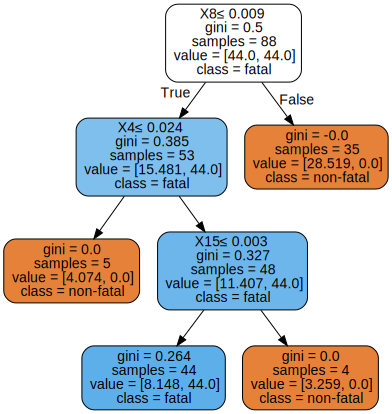

In [7]:
graph

In [18]:
for i, file in enumerate(glob.glob("./inputs/object/*.p")):
    f = open(file,'rb')
    example = pickle.load(f)
    num_clusters = len(example)
    my_sum = 0
    for cluster in example:
        my_sum += len(cluster.cells)
    print(file[16:], "->", num_clusters, ",", my_sum)
    f.close()

_DONEIN700-SN142.p -> 2644 , 13804
